## 1. 환경 설정 및 임포트

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import asyncio
import logging
from pathlib import Path
from dotenv import load_dotenv
from helper_dev_utils import get_auto_logger
logger = get_auto_logger()

# 프로젝트 루트 경로 추가
project_root = Path.cwd().parent.parent
src_path = project_root / "src"

# sys.path에 추가
for path in [str(project_root), str(src_path)]:
    if path not in sys.path:
        sys.path.insert(0, path)
        logger.debug(f"path: {path}")

logger.debug(f"프로젝트 루트: {project_root}")
logger.debug(f"소스 경로: {src_path}")

# 환경 변수 로드
env_path = project_root / ".env"
if env_path.exists():
    load_dotenv(env_path)
    logger.debug(f"환경 변수 로드: {env_path}")
else:
    logger.warning(f".env 파일을 찾을 수 없습니다 ({env_path})")

2026-01-13 00:27:22 D [ipykernel_launcher:18] - path: /home/spai0433/codeit-ai-3team-ad-content
2026-01-13 00:27:22 D [ipykernel_launcher:18] - path: /home/spai0433/codeit-ai-3team-ad-content/src
2026-01-13 00:27:22 D [ipykernel_launcher:20] - 프로젝트 루트: /home/spai0433/codeit-ai-3team-ad-content
2026-01-13 00:27:22 D [ipykernel_launcher:21] - 소스 경로: /home/spai0433/codeit-ai-3team-ad-content/src
2026-01-13 00:27:22 D [ipykernel_launcher:27] - 환경 변수 로드: /home/spai0433/codeit-ai-3team-ad-content/.env


## 2. OpenAI API 키 확인

In [3]:
# OpenAI API 키 확인
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    logger.debug("OPENAI_API_KEY 환경 변수가 설정되지 않았습니다.")
    logger.debug("   .env 파일에 다음을 추가하세요:")
    logger.debug("   OPENAI_API_KEY=sk-...")
else:
    logger.debug(f"OpenAI API 키 확인됨 (길이: {len(openai_api_key)} 문자)")
    logger.debug(f"   키 prefix: {openai_api_key[:5]} --- {openai_api_key[-5:]}")

2026-01-13 00:27:22 D [ipykernel_launcher:9] - OpenAI API 키 확인됨 (길이: 164 문자)
2026-01-13 00:27:22 D [ipykernel_launcher:10] -    키 prefix: sk-pr --- cxzEA


## 3. mcpadapter 임포트 및 초기화

In [4]:
# mcpadapter 임포트
from mcpadapter import MCPClient, LLMAdapter

# 설정
MCP_SERVER_URL = "http://localhost:3000"

logger.info("mcpadapter 임포트 완료")
logger.info(f"   MCP 서버 URL: {MCP_SERVER_URL}")

2026-01-13 00:27:22 I [ipykernel_launcher:7] - mcpadapter 임포트 완료
2026-01-13 00:27:22 I [ipykernel_launcher:8] -    MCP 서버 URL: http://localhost:3000


## 4. 이미지 경로 설정

In [5]:
# ===================================================================
# 환경 변수 기반 경로 설정 (Docker/로컬 자동 감지)
# ===================================================================

def get_static_base_path():
    """
    환경 변수 기반 static 경로 반환
    
    - Docker 환경: RUNTIME_ENV=docker, STATIC_BASE_PATH=/app/static
    - 로컬 환경: RUNTIME_ENV 미설정 또는 'local'
    
    Returns:
        Path: static 디렉토리의 절대 경로
    """
    runtime_env = os.getenv("RUNTIME_ENV", "local")
    
    if runtime_env == "docker":
        # Docker 환경: STATIC_BASE_PATH 환경 변수 사용
        static_base = os.getenv("STATIC_BASE_PATH", "/app/static")
        logger.info(f"🐳 Docker 환경 감지: {static_base}")
    else:
        # 로컬 개발 환경: 프로젝트 루트 기준 상대 경로
        static_base = src_path / "nanoCocoa_aiserver" / "static"
        logger.info(f"💻 로컬 환경 감지: {static_base}")
    
    return Path(static_base)

# 환경별 경로 설정
STATIC_BASE = get_static_base_path()
UPLOADS_DIR = STATIC_BASE / "uploads"
RESULTS_DIR = STATIC_BASE / "results"

# 디렉토리 생성
UPLOADS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# 테스트 이미지 경로
product_image_filename = "test_product.png"
output_image_filename = "banana_ad_result.png"

product_image_path = UPLOADS_DIR / product_image_filename
output_image_path = RESULTS_DIR / output_image_filename

logger.info("=" * 60)
logger.info("경로 설정 완료")
logger.info("=" * 60)
logger.info(f"실행 환경: {os.getenv('RUNTIME_ENV', 'local').upper()}")
logger.info(f"Static 기본 경로: {STATIC_BASE}")
logger.info(f"업로드 디렉토리: {UPLOADS_DIR}")
logger.info(f"결과 디렉토리: {RESULTS_DIR}")
logger.info(f"제품 이미지 경로: {product_image_path}")
logger.info(f"출력 이미지 경로: {output_image_path}")
logger.info("=" * 60)

2026-01-13 00:27:22 I [ipykernel_launcher:24] - 💻 로컬 환경 감지: /home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver/static
2026-01-13 00:27:22 I [ipykernel_launcher:44] - ============================================================
2026-01-13 00:27:22 I [ipykernel_launcher:45] - 경로 설정 완료
2026-01-13 00:27:22 I [ipykernel_launcher:46] - ============================================================
2026-01-13 00:27:22 I [ipykernel_launcher:47] - 실행 환경: LOCAL
2026-01-13 00:27:22 I [ipykernel_launcher:48] - Static 기본 경로: /home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver/static
2026-01-13 00:27:22 I [ipykernel_launcher:49] - 업로드 디렉토리: /home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver/static/uploads
2026-01-13 00:27:22 I [ipykernel_launcher:50] - 결과 디렉토리: /home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver/static/results
2026-01-13 00:27:22 I [ipykernel_launcher:51] - 제품 이미지 경로: /home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver

## 4-0. 이미지 파일 확인 및 생성

**중요**: 테스트용 이미지가 없으면 광고 생성이 실패합니다!

In [6]:
# 테스트 이미지 자동 생성 (필요 시)
if not product_image_path.exists():
    logger.warning(f"이미지 파일이 없습니다: {product_image_path}")
    logger.info("테스트용 제품 이미지를 생성합니다...")
    
    # 디렉토리 권한 확인 및 수정
    import stat
    if UPLOADS_DIR.exists():
        current_mode = UPLOADS_DIR.stat().st_mode
        logger.info(f"현재 디렉토리 권한: {oct(stat.S_IMODE(current_mode))}")
        
        # 쓰기 권한 부여 (755)
        try:
            UPLOADS_DIR.chmod(0o755)
            logger.info("디렉토리 권한 수정 완료 (755)")
        except Exception as e:
            logger.warning(f"권한 수정 실패 (무시하고 계속): {e}")
    
    from PIL import Image, ImageDraw, ImageFont
    
    # 512x512 바나나 이미지 생성
    img = Image.new('RGB', (512, 512), color='white')
    draw = ImageDraw.Draw(img)
    
    # 바나나 모양 그리기
    draw.ellipse([150, 100, 450, 200], fill='#FFD700', outline='#FFA500', width=3)
    draw.ellipse([100, 200, 400, 300], fill='#FFD700', outline='#FFA500', width=3)
    draw.ellipse([120, 280, 380, 400], fill='#FFD700', outline='#FFA500', width=3)
    
    # 저장
    try:
        img.save(product_image_path)
        logger.info(f"테스트 이미지 생성 완료: {product_image_path}")
        logger.info(f"   크기: {product_image_path.stat().st_size:,} bytes")
    except PermissionError as e:
        logger.error(f"저장 실패 (권한 오류): {e}")
        logger.info("해결 방법:")
        logger.info(f"   터미널에서 실행: chmod 755 {UPLOADS_DIR}")
        raise
else:
    logger.info(f"이미지 파일 존재: {product_image_path}")
    logger.info(f"   크기: {product_image_path.stat().st_size:,} bytes")

2026-01-13 00:27:22 I [ipykernel_launcher:41] - 이미지 파일 존재: /home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver/static/uploads/test_product.png
2026-01-13 00:27:22 I [ipykernel_launcher:42] -    크기: 285,210 bytes


## 4-0-1. 디렉토리 권한 확인 및 수정

**중요**: Docker 볼륨 마운트 디렉토리에 쓰기 권한이 필요합니다.

In [7]:
# 디렉토리 권한 확인 및 수정
import stat

logger.info("=" * 60)
logger.info("디렉토리 권한 확인")
logger.info("=" * 60)

for dir_name, dir_path in [
    ("업로드", UPLOADS_DIR),
    ("결과", RESULTS_DIR)
]:
    if dir_path.exists():
        current_mode = dir_path.stat().st_mode
        mode_oct = oct(stat.S_IMODE(current_mode))
        logger.info(f"{dir_name} 디렉토리: {dir_path}")
        logger.info(f"   현재 권한: {mode_oct}")
        
        # 쓰기 권한 확인
        if not os.access(dir_path, os.W_OK):
            logger.warning(f"   쓰기 권한 없음!")
            logger.info(f"   권한 수정 시도 중...")
            
            try:
                # 777 권한 부여 (모든 사용자 읽기/쓰기/실행)
                dir_path.chmod(0o777)
                logger.info(f"   권한 수정 완료 (777)")
            except Exception as e:
                logger.error(f"   권한 수정 실패: {e}")
                logger.info(f"   터미널에서 실행하세요:")
                logger.info(f"      chmod 777 {dir_path}")
        else:
            logger.info(f"   쓰기 권한 있음")
    else:
        logger.warning(f"{dir_name} 디렉토리 없음: {dir_path}")

logger.info("=" * 60)

2026-01-13 00:27:22 I [ipykernel_launcher:4] - ============================================================
2026-01-13 00:27:22 I [ipykernel_launcher:5] - 디렉토리 권한 확인
2026-01-13 00:27:22 I [ipykernel_launcher:6] - ============================================================
2026-01-13 00:27:22 I [ipykernel_launcher:15] - 업로드 디렉토리: /home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver/static/uploads
2026-01-13 00:27:22 I [ipykernel_launcher:16] -    현재 권한: 0o775
2026-01-13 00:27:22 I [ipykernel_launcher:32] -    쓰기 권한 있음
2026-01-13 00:27:22 I [ipykernel_launcher:15] - 결과 디렉토리: /home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver/static/results
2026-01-13 00:27:22 I [ipykernel_launcher:16] -    현재 권한: 0o775
2026-01-13 00:27:22 I [ipykernel_launcher:32] -    쓰기 권한 있음
2026-01-13 00:27:22 I [ipykernel_launcher:36] - ============================================================


## 4-1. 서버 상태 대기 헬퍼 함수

In [8]:
async def wait_for_server_ready(max_wait_sec: int = 300, check_interval: int = 10) -> bool:
    """
    AI 서버가 idle 상태가 될 때까지 대기
    
    Args:
        max_wait_sec: 최대 대기 시간 (초, 기본값 300초 = 5분)
        check_interval: 상태 확인 간격 (초, 기본값 10초)
    
    Returns:
        True: 서버가 idle 상태
        False: 타임아웃 발생
    """
    logger.info(f"🕐 AI 서버 idle 상태 대기 중... (최대 {max_wait_sec}초)")
    
    async with MCPClient(
        base_url=MCP_SERVER_URL,
        timeout=30
    ) as client:
        elapsed = 0
        while elapsed < max_wait_sec:
            health = await client.call_tool("check_server_health", {})
            
            # health가 문자열인 경우 파싱
            if isinstance(health, str):
                # "상태: busy" 또는 "상태: idle" 패턴 찾기
                if "idle" in health.lower():
                    logger.info(f"   서버 idle 상태 확인 (대기 시간: {elapsed}초)")
                    return True
                elif "busy" in health.lower():
                    logger.info(f"   ⏳ 서버 busy 상태... {check_interval}초 후 재확인 (경과: {elapsed}초/{max_wait_sec}초)")
                else:
                    # 상태를 알 수 없으면 바로 진행
                    logger.warning(f"   서버 상태 불명: {health}")
                    return True
            else:
                # dict 형태인 경우
                status = health.get("status", "unknown") if isinstance(health, dict) else "unknown"
                if status == "idle":
                    logger.info(f"   서버 idle 상태 확인 (대기 시간: {elapsed}초)")
                    return True
                elif status == "busy":
                    logger.info(f"   ⏳ 서버 busy 상태... {check_interval}초 후 재확인 (경과: {elapsed}초/{max_wait_sec}초)")
                else:
                    logger.warning(f"   서버 상태: {status}")
                    return True
                
            await asyncio.sleep(check_interval)
            elapsed += check_interval
        
        logger.warning(f"   ⏰ 타임아웃: {max_wait_sec}초 동안 서버가 idle 상태가 되지 않음")
        return False

logger.info("서버 대기 헬퍼 함수 정의 완료")

2026-01-13 00:27:22 I [ipykernel_launcher:53] - 서버 대기 헬퍼 함수 정의 완료


## 7. LLMAdapter를 통한 자연어 광고 생성

LLMAdapter는 자연어 요청을 자동으로 MCP 도구 호출로 변환합니다.

In [9]:
import re
import json

async def generate_ad_with_llm():
    """
    LLMAdapter를 사용한 자연어 광고 생성
    """
    logger.info("=" * 60)
    logger.info("LLMAdapter 광고 생성 테스트")
    logger.info("=" * 60)
    
    # OpenAI API 키 확인
    openai_api_key = os.getenv("OPENAI_API_KEY")
    if not openai_api_key:
        logger.error("OPENAI_API_KEY 환경 변수가 설정되지 않았습니다.")
        return
    
    # LLMAdapter 초기화 및 자연어 요청
    async with LLMAdapter(
        openai_api_key=openai_api_key,
        mcp_server_url=MCP_SERVER_URL,
        model="gpt-5-mini",
    ) as adapter:
        
        user_request = f"""
사용자: 바나나 특가 광고 만들어줘

- product_image_path: "{product_image_path}"
- save_output_path: "{output_image_path}"
- text_content: "맛있는바나나 2500원"
- wait_for_completion: false
- composition_mode: "overlay"

모든 프롬프트는 영문으로 작성하세요.
"""
        
        logger.info("자연어 요청 전송 중...")
        logger.info(f"요청 내용:\n{user_request[:250]}...")
        
        # max_tool_calls=1: 도구만 호출 (LLM 응답 불필요)
        # 대신 adapter.conversation_history에서 도구 응답 추출
        response = await adapter.chat(user_request, max_tool_calls=1)
        
        # 도구 호출 결과를 conversation_history에서 추출
        tool_response = None
        for msg in reversed(adapter.conversation_history):
            if msg.get("role") == "tool":
                tool_response = msg.get("content")
                break
        
        logger.info("=" * 60)
        logger.info("도구 호출 결과")
        logger.info("=" * 60)
        if tool_response:
            logger.info(f"Tool Response: {tool_response[:300]}...")
        else:
            logger.warning("도구 호출 결과를 찾을 수 없습니다.")
        
        # LLM 응답 무시 (max_tool_calls=1 제한 메시지)
        
        # job_id 추출 우선순위:
        # 1. 도구 응답에서 JSON 파싱 (최우선)
        if tool_response:
            try:
                # JSON 파싱 시도
                tool_data = json.loads(tool_response)
                if "job_id" in tool_data:
                    job_id = tool_data["job_id"]
                    logger.info(f"도구 응답(JSON)에서 추출된 Job ID: {job_id}")
                    return job_id
            except json.JSONDecodeError:
                # UUID 패턴 검색
                uuid_pattern = r'[a-f0-9]{8}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{12}'
                matches = re.findall(uuid_pattern, tool_response, re.IGNORECASE)
                if matches:
                    job_id = matches[0]
                    logger.info(f"도구 응답(UUID)에서 추출된 Job ID: {job_id}")
                    return job_id
        
        # 2. LLM 응답에서 JSON 파싱 시도
        try:
            # JSON 블록 찾기 (```json ... ``` 또는 직접 JSON)
            json_match = re.search(r'```json\s*(\{.*?\})\s*```', response, re.DOTALL)
            if json_match:
                data = json.loads(json_match.group(1))
            else:
                # 직접 JSON 파싱 시도
                data = json.loads(response)
            
            if "job_id" in data:
                job_id = data["job_id"]
                logger.info(f"LLM 응답(JSON)에서 추출된 Job ID: {job_id}")
                return job_id
        except (json.JSONDecodeError, KeyError, TypeError) as e:
            logger.debug(f"JSON 파싱 실패 (다음 방법 시도): {e}")
        
        # 3. UUID 패턴 검색
        uuid_pattern = r'[a-f0-9]{8}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{12}'
        matches = re.findall(uuid_pattern, response, re.IGNORECASE)
        if matches:
            job_id = matches[0]
            logger.info(f"UUID 패턴에서 추출된 Job ID: {job_id}")
            return job_id
        
        # 4. 작업 ID 레이블 패턴 (한글/영문)
        match = re.search(r'(?:작업|Job|Task)\s*(?:ID|id)[:\s]*([a-f0-9\-]+)', response, re.IGNORECASE)
        if match:
            job_id = match.group(1)
            logger.info(f"레이블 패턴에서 추출된 Job ID: {job_id}")
            return job_id
        
        logger.warning("job_id를 찾을 수 없습니다.")
        logger.info(f"도구 응답:\n{tool_response}")
        logger.info(f"LLM 응답:\n{response}")
        return None

# 실행
job_id = await generate_ad_with_llm()


2026-01-13 00:27:22 I [ipykernel_launcher:8] - ============================================================
2026-01-13 00:27:22 I [ipykernel_launcher:9] - LLMAdapter 광고 생성 테스트
2026-01-13 00:27:22 I [ipykernel_launcher:10] - ============================================================
2026-01-13 00:27:23 I [mcp_client:51] - MCPClient 초기화: base_url=http://localhost:3000
2026-01-13 00:27:23 I [ipykernel_launcher:37] - 자연어 요청 전송 중...
2026-01-13 00:27:23 I [ipykernel_launcher:38] - 요청 내용:

사용자: 바나나 특가 광고 만들어줘

- product_image_path: "/home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver/static/uploads/test_product.png"
- save_output_path: "/home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver/static/results/banana...
2026-01-13 00:27:57 I [llm_adapter:330] - MCP 도구 호출 tool_name=generate_ad_image
2026-01-13 00:27:57 I [llm_adapter:331] - MCP 도구 호출 tool_args={'product_image_path': '/home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver/static/uploads/test_produc

In [10]:
async def test_llm_basic():
    """
    LLMAdapter 기본 테스트: 서버 상태 확인
    """
    logger.info("=" * 60)
    logger.info("LLMAdapter 기본 테스트")
    logger.info("=" * 60)
    
    openai_api_key = os.getenv("OPENAI_API_KEY")
    if not openai_api_key:
        logger.error("OPENAI_API_KEY 환경 변수가 설정되지 않았습니다.")
        return
    
    async with LLMAdapter(
        openai_api_key=openai_api_key,
        mcp_server_url=MCP_SERVER_URL,
        model="gpt-5-mini",
    ) as adapter:
        
        # 1. 서버 상태 확인
        response1 = await adapter.chat("AI 서버 상태를 확인해줘")
        logger.info(f"서버 상태 응답:\n{response1}")
        
        # 2. 폰트 목록 확인
        response2 = await adapter.chat("사용 가능한 폰트 목록을 알려줘")
        logger.info(f"폰트 목록 응답:\n{response2[:300]}...")

# 실행
await test_llm_basic()

2026-01-13 00:28:06 I [ipykernel_launcher:5] - ============================================================
2026-01-13 00:28:06 I [ipykernel_launcher:6] - LLMAdapter 기본 테스트
2026-01-13 00:28:06 I [ipykernel_launcher:7] - ============================================================
2026-01-13 00:28:06 I [mcp_client:51] - MCPClient 초기화: base_url=http://localhost:3000
2026-01-13 00:28:08 I [llm_adapter:330] - MCP 도구 호출 tool_name=check_server_health
2026-01-13 00:28:08 I [llm_adapter:331] - MCP 도구 호출 tool_args={}
2026-01-13 00:28:08 I [llm_adapter:336] - MCP 도구 호출 성공: 서버 상태: busy
전체 작업: 1개
활성 작업: 1개

시스템 리소스:
  CPU: 29.8%
  RAM: 5.0/15.6 GB (32.2%)
  GPU 0 (NVIDIA L4): 0%, VRAM: 0.5/22.5 GB
...
2026-01-13 00:28:17 I [ipykernel_launcher:22] - 서버 상태 응답:
AI 서버 상태 확인 결과입니다:

- 서버 상태: busy (작업 중)
- 전체 작업 수: 1개
- 활성(실행중) 작업: 1개

시스템 리소스:
- CPU 사용률: 29.8%
- RAM 사용량: 5.0 / 15.6 GB (약 32.2%)
- GPU 0 (NVIDIA L4): 사용률 0%, VRAM 사용 0.5 / 22.5 GB

해석 및 권장사항:
- 현재 1개의 활성 작업이 있어 상태는 "busy"로 표시되지만 CPU·RAM 부

## 7-1. LLMAdapter 간단 테스트 (서버 상태 확인)

In [11]:
# Step 2: 작업 상태 조회 (폴링) - 완료 시 이미지 저장 포함
import json

async def check_ad_generation_status(
    job_id: str, 
    save_result_path: str = None,
    max_attempts: int = 300, 
    interval: int = 10
):
    """
    Job ID로 작업 상태를 확인하고 완료 시 이미지를 저장
    
    Args:
        job_id: 확인할 작업 ID
        save_result_path: 완료 시 저장할 이미지 경로 (중요!)
        max_attempts: 최대 시도 횟수 (기본값: 300회)
        interval: 확인 간격 (초, 기본값: 10초)
    
    Returns:
        최종 상태 결과
    """
    logger.info("=" * 60)
    logger.info(f"Step 2: 작업 상태 확인 (Job ID: {job_id})")
    if save_result_path:
        logger.info(f"완료 시 저장 경로: {save_result_path}")
    logger.info("=" * 60)
    
    async with MCPClient(
        base_url=MCP_SERVER_URL,
        timeout=30
    ) as client:
        
        attempt = 0
        while attempt < max_attempts:
            await asyncio.sleep(interval)
            attempt += 1
            
            # 상태 확인 (save_result_path 전달!)
            status_params = {"job_id": job_id}
            if save_result_path:
                status_params["save_result_path"] = save_result_path
            
            status_result = await client.call_tool(
                "check_generation_status",
                status_params
            )
            
            # JSON 파싱 시도
            try:
                if isinstance(status_result, str):
                    status_data = json.loads(status_result)
                else:
                    status_data = status_result
                
                status = status_data.get("status")
                progress = status_data.get("progress_percent", 0)
                
                logger.info(f"   [{attempt}/{max_attempts}] status={status}, progress={progress}%")
                
                if status == "completed":
                    logger.info("작업 완료!")
                    if save_result_path:
                        logger.info(f"   이미지 저장됨: {save_result_path}")
                    return status_data
                elif status == "failed":
                    logger.error(f"작업 실패: {status_data.get('message')}")
                    return status_data
                else:
                    logger.info(f"   진행 중... (단계: {status_data.get('current_step')})")
                    
            except (json.JSONDecodeError, AttributeError) as e:
                # Fallback: 문자열 응답 처리
                logger.debug(f"JSON 파싱 실패, 텍스트 분석: {e}")
                logger.info(f"   [{attempt}/{max_attempts}] 상태: {status_result}")
                
                if isinstance(status_result, dict):
                    status = status_result.get("status")
                    progress = status_result.get("progress", 0)
                    
                    if status == "completed":
                        logger.info("작업 완료!")
                        if save_result_path:
                            logger.info(f"   이미지 저장됨: {save_result_path}")
                        return status_result
                    elif status == "failed":
                        logger.error(f"작업 실패: {status_result.get('error')}")
                        return status_result
                else:
                    # 문자열 검색
                    if "completed" in str(status_result).lower():
                        logger.info("작업 완료!")
                        if save_result_path:
                            logger.info(f"   이미지 저장됨: {save_result_path}")
                        return status_result
                    elif "failed" in str(status_result).lower():
                        logger.error(f"작업 실패: {status_result}")
                        return status_result
        
        logger.warning(f"⏰ 타임아웃: {max_attempts * interval}초 동안 작업이 완료되지 않음")
        return {"status": "timeout", "message": "작업이 제한 시간 내에 완료되지 않았습니다."}
        

# 실행 (job_id를 앞 셀에서 받아야 함)
if 'job_id' in dir() and job_id:
    status_result = await check_ad_generation_status(
        job_id, 
        save_result_path=str(output_image_path)
    )
else:
    logger.warning("job_id가 없습니다. 먼저 이전 셀을 실행하세요.")


2026-01-13 00:28:29 I [ipykernel_launcher:22] - ============================================================
2026-01-13 00:28:29 I [ipykernel_launcher:23] - Step 2: 작업 상태 확인 (Job ID: cce2e978-cd84-45e3-994b-421187ca6e17)
2026-01-13 00:28:29 I [ipykernel_launcher:25] - 완료 시 저장 경로: /home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver/static/results/banana_ad_result.png
2026-01-13 00:28:29 I [ipykernel_launcher:26] - ============================================================
2026-01-13 00:28:29 I [mcp_client:51] - MCPClient 초기화: base_url=http://localhost:3000
2026-01-13 00:28:39 I [ipykernel_launcher:58] -    [1/300] status=running, progress=0%
2026-01-13 00:28:39 I [ipykernel_launcher:69] -    진행 중... (단계: step1_background)
2026-01-13 00:28:49 I [ipykernel_launcher:58] -    [2/300] status=running, progress=0%
2026-01-13 00:28:49 I [ipykernel_launcher:69] -    진행 중... (단계: step1_background)
2026-01-13 00:28:59 I [ipykernel_launcher:58] -    [3/300] status=running, progress=0

2026-01-13 00:43:11 I [ipykernel_launcher:8] - ============================================================
2026-01-13 00:43:11 I [ipykernel_launcher:9] - Step 3: 결과 확인 및 출력
2026-01-13 00:43:11 I [ipykernel_launcher:10] - ============================================================
2026-01-13 00:43:11 I [ipykernel_launcher:14] - 광고 이미지 생성 완료!
2026-01-13 00:43:11 I [ipykernel_launcher:15] -    경로: /home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver/static/results/banana_ad_result.png
2026-01-13 00:43:11 I [ipykernel_launcher:16] -    크기: 1,153,257 bytes (1126.2 KB)
2026-01-13 00:43:11 I [ipykernel_launcher:17] - 이미지 표시:


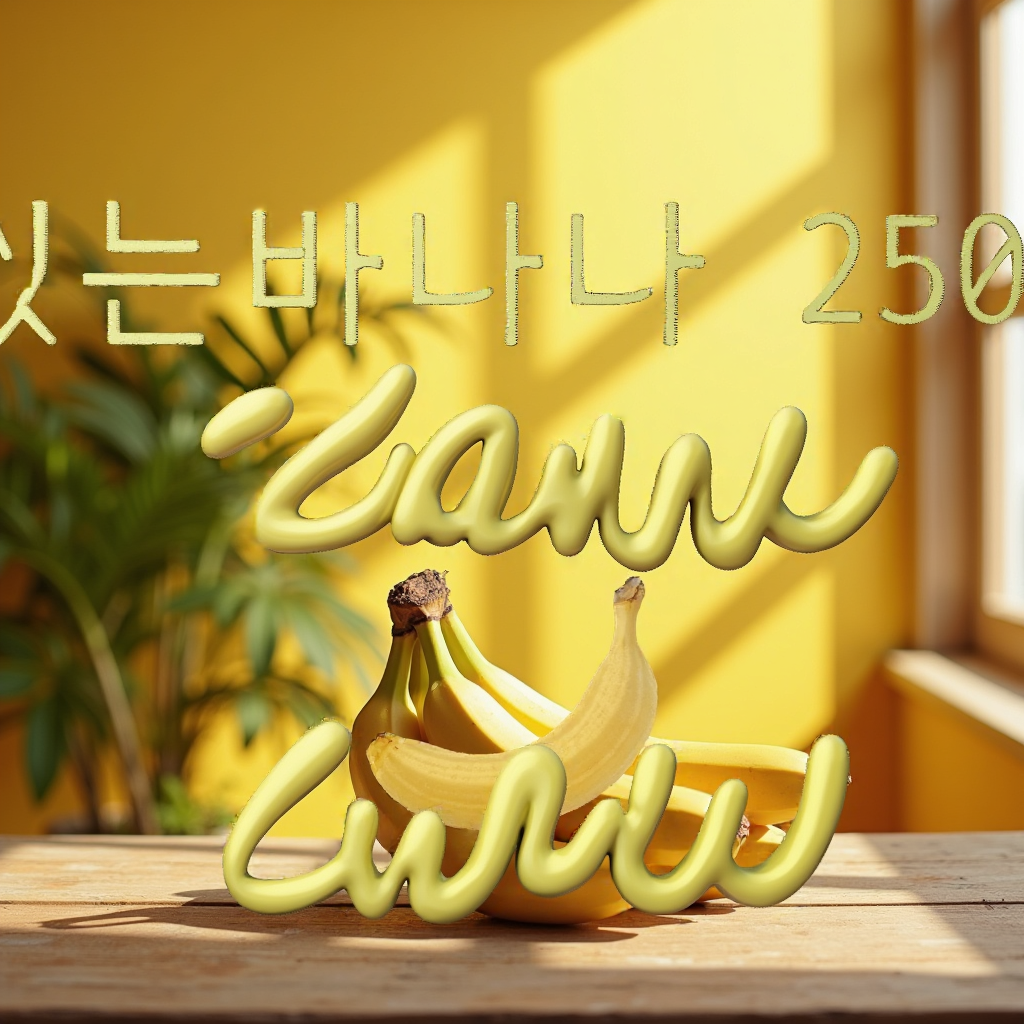

In [12]:
from IPython.display import Image, display

# Step 3: 결과 확인 및 출력
def display_ad_result():
    """
    생성된 광고 이미지 확인 및 표시
    """
    logger.info("=" * 60)
    logger.info("Step 3: 결과 확인 및 출력")
    logger.info("=" * 60)
    
    if output_image_path.exists():
        file_size = output_image_path.stat().st_size
        logger.info(f"광고 이미지 생성 완료!")
        logger.info(f"   경로: {output_image_path}")
        logger.info(f"   크기: {file_size:,} bytes ({file_size / 1024:.1f} KB)")
        logger.info("이미지 표시:")
        display(Image(filename=str(output_image_path)))
        
    else:
        logger.error(f"출력 이미지를 찾을 수 없습니다: {output_image_path}")
        logger.info("확인사항:")
        logger.info(f"   1. 작업이 정상 완료되었는지 확인")
        logger.info(f"   2. 결과 디렉토리 존재 여부: {RESULTS_DIR.exists()}")
        if RESULTS_DIR.exists():
            files = list(RESULTS_DIR.glob("*"))
            logger.info(f"   3. 결과 디렉토리 파일 목록:")
            for f in files:
                logger.info(f"      - {f.name} ({f.stat().st_size:,} bytes)")

# 실행
display_ad_result()

In [ ]:
async def test_llm_font_recommendation():
    """
    LLMAdapter를 통한 폰트 추천 테스트
    """
    logger.info("=" * 60)
    logger.info("LLMAdapter 폰트 추천 테스트")
    logger.info("=" * 60)
    
    openai_api_key = os.getenv("OPENAI_API_KEY")
    if not openai_api_key:
        logger.error("OPENAI_API_KEY 환경 변수가 설정되지 않았습니다.")
        return
    
    async with LLMAdapter(
        openai_api_key=openai_api_key,
        mcp_server_url=MCP_SERVER_URL,
        model="gpt-5-mini",
    ) as adapter:
        
        test_cases = [
            "50% 할인 세일 광고에 어울리는 굵은 폰트 추천해줘",
            "명품 프리미엄 광고에 우아한 폰트 추천해줘",
            "친근한 캐주얼 광고에 손글씨 느낌 폰트 추천해줘"
        ]
        
        for i, request in enumerate(test_cases, 1):
            logger.info(f"\n[테스트 {i}] {request}")
            response = await adapter.chat(request)
            logger.info(f"응답:\n{response}\n")

# 실행
await test_llm_font_recommendation()

2026-01-13 00:43:12 I [ipykernel_launcher:5] - ============================================================
2026-01-13 00:43:12 I [ipykernel_launcher:6] - LLMAdapter 폰트 추천 테스트
2026-01-13 00:43:12 I [ipykernel_launcher:7] - ============================================================
2026-01-13 00:43:12 I [mcp_client:51] - MCPClient 초기화: base_url=http://localhost:3000
2026-01-13 00:43:12 I [ipykernel_launcher:27] - 
[테스트 1] 50% 할인 세일 광고에 어울리는 굵은 폰트 추천해줘
2026-01-13 00:43:13 I [llm_adapter:330] - MCP 도구 호출 tool_name=recommend_font_for_ad
2026-01-13 00:43:13 I [llm_adapter:331] - MCP 도구 호출 tool_args={'text_content': '50% 할인', 'ad_type': 'sale', 'weight_preference': 'bold'}
2026-01-13 00:43:13 I [llm_adapter:336] - MCP 도구 호출 성공: 추천 폰트: 나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothicBold.ttf
스타일: gothic
굵기: bold
용도: title, body, promotion, sale
톤: modern, clean, professional, energetic
선택 이유: 광고 유형(sale), 스타일(gothic), 굵기(bold)를 고려하...
2026-01-13 00:43:16 I [ipykernel_launcher:29] - 응답:
50% 할인 세일 

## 8. LLMAdapter를 통한 폰트 추천 테스트

In [14]:
# 간단한 테스트: 서버 상태 확인
async def quick_test():
    """MCP 서버 연결 및 상태 확인"""
    logger.info("=== 빠른 연결 테스트 ===")
    
    async with MCPClient(
        base_url=MCP_SERVER_URL,
        timeout=30
    ) as client:
        # 서버 상태 확인
        health = await client.call_tool("check_server_health", {})
        logger.info(f"서버 상태:\n{health}")
        
        # 폰트 목록 확인
        fonts = await client.call_tool("list_available_fonts", {})
        logger.info(f"사용 가능한 폰트:\n{fonts}")
        
    logger.info("=== 테스트 완료 ===")

await quick_test()


2026-01-13 00:43:22 I [ipykernel_launcher:4] - === 빠른 연결 테스트 ===
2026-01-13 00:43:22 I [mcp_client:51] - MCPClient 초기화: base_url=http://localhost:3000
2026-01-13 00:43:22 I [ipykernel_launcher:12] - 서버 상태:
서버 상태: healthy
전체 작업: 1개
활성 작업: 0개

시스템 리소스:
  CPU: 1.9%
  RAM: 1.8/15.6 GB (11.4%)
  GPU 0 (NVIDIA L4): 0%, VRAM: 0.5/22.5 GB

2026-01-13 00:43:22 I [ipykernel_launcher:16] - 사용 가능한 폰트:
사용 가능한 폰트 (54개):

  - D2coding/D2CodingLigature/D2Coding-Ver1.3.2-20180524-ligature.ttf
  - D2coding/D2CodingLigature/D2CodingBold-Ver1.3.2-20180524-ligature.ttf
  - NanumSquareNeo/NanumSquareNeo/NanumSquareNeo-Variable.ttf
  - NanumSquareNeo/NanumSquareNeo/TTF/NanumSquareNeo-aLt.ttf
  - NanumSquareNeo/NanumSquareNeo/TTF/NanumSquareNeo-bRg.ttf
  - NanumSquareNeo/NanumSquareNeo/TTF/NanumSquareNeo-cBd.ttf
  - NanumSquareNeo/NanumSquareNeo/TTF/NanumSquareNeo-dEb.ttf
  - NanumSquareNeo/NanumSquareNeo/TTF/NanumSquareNeo-eHv.ttf
  - 나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf
  - 나눔고딕/NanumFontSetup_TTF

## 폰트 자동 선택 테스트

In [15]:
# 1. 폰트 메타데이터 조회
async def test_font_metadata():
    """폰트 메타데이터 조회 테스트"""
    logger.info("=== 폰트 메타데이터 조회 ===")
    
    async with MCPClient(
        base_url=MCP_SERVER_URL,
        timeout=30
    ) as client:
        # 폰트 메타데이터 조회
        metadata = await client.call_tool("get_fonts_metadata", {})
        logger.info(f"폰트 메타데이터:\n{metadata[:500]}...")  # 일부만 출력
    
    logger.info("=== 테스트 완료 ===")

await test_font_metadata()

2026-01-13 00:43:22 I [ipykernel_launcher:4] - === 폰트 메타데이터 조회 ===
2026-01-13 00:43:22 I [mcp_client:51] - MCPClient 초기화: base_url=http://localhost:3000
2026-01-13 00:43:22 I [ipykernel_launcher:12] - 폰트 메타데이터:
[
  {
    "name": "D2coding/D2CodingLigature/D2Coding-Ver1.3.2-20180524-ligature.ttf",
    "style": "mono",
    "weight": "regular",
    "usage": [
      "code",
      "technical"
    ],
    "tone": [
      "tech",
      "modern"
    ]
  },
  {
    "name": "D2coding/D2CodingLigature/D2CodingBold-Ver1.3.2-20180524-ligature.ttf",
    "style": "mono",
    "weight": "bold",
    "usage": [
      "code",
      "technical"
    ],
    "tone": [
      "tech",
      "modern"
    ]
  },
  {
    "name": "Na...
2026-01-13 00:43:22 I [ipykernel_launcher:14] - === 테스트 완료 ===


In [16]:
# 서버에 등록된 툴 목록 확인
async def check_available_tools():
    """MCP 서버에 등록된 툴 목록 확인"""
    logger.info("=== 서버 등록 툴 확인 ===")
    
    async with MCPClient(
        base_url=MCP_SERVER_URL,
        timeout=30
    ) as client:
        # httpx를 직접 사용하여 /tools 엔드포인트 호출
        response = await client._client.get(f"{MCP_SERVER_URL}/tools")
        response.raise_for_status()
        data = response.json()
        
        tools = data.get("tools", [])
        logger.info(f"등록된 툴 개수: {len(tools)}")
        logger.info("툴 목록:")
        for tool in tools:
            logger.info(f"  - {tool['name']}: {tool['description'][:80]}...")
    
    logger.info("=== 확인 완료 ===")

await check_available_tools()

2026-01-13 00:43:22 I [ipykernel_launcher:4] - === 서버 등록 툴 확인 ===
2026-01-13 00:43:22 I [mcp_client:51] - MCPClient 초기화: base_url=http://localhost:3000
2026-01-13 00:43:22 I [ipykernel_launcher:16] - 등록된 툴 개수: 13
2026-01-13 00:43:22 I [ipykernel_launcher:17] - 툴 목록:
2026-01-13 00:43:22 I [ipykernel_launcher:19] -   - generate_ad_image: 제품 이미지를 기반으로 AI가 전문적인 광고 이미지를 생성합니다. 3단계 파이프라인(배경 생성 → 3D 텍스트 생성 → 최종 합성)을 자동으로 ...
2026-01-13 00:43:22 I [ipykernel_launcher:19] -   - check_generation_status: 비동기로 시작된 광고 생성 작업의 현재 진행 상태를 확인합니다....
2026-01-13 00:43:22 I [ipykernel_launcher:19] -   - stop_generation: 실행 중인 광고 생성 작업을 강제로 중단합니다....
2026-01-13 00:43:22 I [ipykernel_launcher:19] -   - list_available_fonts: 텍스트 렌더링에 사용할 수 있는 폰트 목록을 반환합니다....
2026-01-13 00:43:22 I [ipykernel_launcher:19] -   - get_fonts_metadata: 폰트별 상세 메타데이터(스타일, 굵기, 용도, 톤앤매너)를 조회하여 광고 콘텐츠에 적합한 폰트를 선택할 수 있습니다....
2026-01-13 00:43:22 I [ipykernel_launcher:19] -   - recommend_font_for_ad: 광고 콘텐츠와 유형에 따라 적합한 폰트를 자동으로 추천합니다....


In [17]:
# 2. 세일 광고용 폰트 추천
async def test_font_recommendation_sale():
    """세일 광고용 폰트 추천 테스트"""
    logger.info("=== 세일 광고용 폰트 추천 ===")
    
    async with MCPClient(
        base_url=MCP_SERVER_URL,
        timeout=30
    ) as client:
        # 한글 세일 광고용 폰트 추천
        result = await client.call_tool("recommend_font_for_ad", {
            "text_content": "50% 할인",
            "ad_type": "sale",
            "weight_preference": "bold"
        })
        logger.info(f"추천 결과:\n{result}")
    
    logger.info("=== 테스트 완료 ===")

await test_font_recommendation_sale()

2026-01-13 00:43:22 I [ipykernel_launcher:4] - === 세일 광고용 폰트 추천 ===
2026-01-13 00:43:22 I [mcp_client:51] - MCPClient 초기화: base_url=http://localhost:3000
2026-01-13 00:43:22 I [ipykernel_launcher:16] - 추천 결과:
추천 폰트: 나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothicBold.ttf
스타일: gothic
굵기: bold
용도: title, body, promotion, sale
톤: modern, clean, professional, energetic
선택 이유: 광고 유형(sale), 스타일(gothic), 굵기(bold)를 고려하여 선택했습니다.
2026-01-13 00:43:22 I [ipykernel_launcher:18] - === 테스트 완료 ===


In [18]:
# 3. 프리미엄 광고용 폰트 추천
async def test_font_recommendation_premium():
    """프리미엄 광고용 폰트 추천 테스트"""
    logger.info("=== 프리미엄 광고용 폰트 추천 ===")
    
    async with MCPClient(
        base_url=MCP_SERVER_URL,
        timeout=30
    ) as client:
        # 한글 프리미엄 광고용 폰트 추천
        result = await client.call_tool("recommend_font_for_ad", {
            "text_content": "명품 한정판",
            "ad_type": "premium",
            "tone": "elegant"
        })
        logger.info(f"추천 결과:\n{result}")
    
    logger.info("=== 테스트 완료 ===")

await test_font_recommendation_premium()

2026-01-13 00:43:22 I [ipykernel_launcher:4] - === 프리미엄 광고용 폰트 추천 ===
2026-01-13 00:43:22 I [mcp_client:51] - MCPClient 초기화: base_url=http://localhost:3000
2026-01-13 00:43:22 I [ipykernel_launcher:16] - 추천 결과:
추천 폰트: 나눔명조/NanumFontSetup_TTF_MYUNGJO/NanumMyeongjo.ttf
스타일: serif
굵기: regular
용도: title, body, premium
톤: elegant, traditional, sophisticated
선택 이유: 광고 유형(premium), 스타일(serif), 굵기(regular)를 고려하여 선택했습니다.
2026-01-13 00:43:22 I [ipykernel_launcher:18] - === 테스트 완료 ===


In [19]:
# 4. 캐주얼 광고용 폰트 추천
async def test_font_recommendation_casual():
    """캐주얼 광고용 폰트 추천 테스트"""
    logger.info("=== 캐주얼 광고용 폰트 추천 ===")
    
    async with MCPClient(
        base_url=MCP_SERVER_URL,
        timeout=30
    ) as client:
        # 손글씨 스타일 폰트 추천
        result = await client.call_tool("recommend_font_for_ad", {
            "text_content": "친구야 놀러와",
            "ad_type": "casual",
            "tone": "friendly"
        })
        logger.info(f"추천 결과:\n{result}")
    
    logger.info("=== 테스트 완료 ===")

await test_font_recommendation_casual()

2026-01-13 00:43:23 I [ipykernel_launcher:4] - === 캐주얼 광고용 폰트 추천 ===
2026-01-13 00:43:23 I [mcp_client:51] - MCPClient 초기화: base_url=http://localhost:3000
2026-01-13 00:43:23 I [ipykernel_launcher:16] - 추천 결과:
추천 폰트: 나눔바른펜/NanumFontSetup_TTF_BARUNPEN/NanumBarunpenB.ttf
스타일: handwriting
굵기: bold
용도: title, accent, casual
톤: friendly, warm, personal
선택 이유: 광고 유형(casual), 스타일(handwriting), 굵기(bold)를 고려하여 선택했습니다.
2026-01-13 00:43:23 I [ipykernel_launcher:18] - === 테스트 완료 ===
